# NYC Taxi Classification and Clustering

This notebook implements supervised learning (Random Forest, XGBoost) to classify high-demand zones and clustering (K-means, DBSCAN) to group demand hotspots for our AI course project. We use contextual features (weather, time, speed) to predict demand without leakage, and enhance clustering with temporal features and descriptive labels. Results feed into the Streamlit dashboard for driver recommendations.

**Contribution of Saleh**: Classification, clustering, feature importance, cluster statistics, and dashboard integration lead.

## Step 1: Import Libraries
We need scikit-learn for ML, XGBoost for classification, Folium for maps, and Matplotlib for visualizations.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pickle
import folium
import os

# Define base URL for file paths
base_url = "/Users/saleh/Desktop/Projects/AIProject/TaxiOptimization/"

## Step 2: Load Data
Load the processed dataset from `preprocessing.py`.

In [2]:
# Load processed data
data_path = base_url + "data/processed/cleaned_taxi_data.csv"
try:
    df = pd.read_csv(data_path)
    print(f"Loaded {len(df)} rows from cleaned_taxi_data.csv")
except FileNotFoundError:
    print(f"Error: {data_path} not found")
    raise

Loaded 17290240 rows from cleaned_taxi_data.csv


## Step 3: Prepare Classification Data
Define high-demand zones (pickups > 80th percentile) and aggregate features, excluding `pickup_count` to avoid leakage.

In [3]:
# Classification: Prepare data for high-demand zones
pickup_counts = df.groupby(["PULocationID", "hour"])["VendorID"].count().reset_index(name="pickup_count")
threshold = pickup_counts["pickup_count"].quantile(0.8)
pickup_counts["is_high_demand"] = (pickup_counts["pickup_count"] > threshold).astype(int)
features = df.groupby(["PULocationID", "hour"]).agg({
    "temperature": "mean",
    "precipitation": "mean",
    "wind_speed": "mean",
    "is_holiday": "mean",
    "avg_speed": "mean",
    "day_of_week": "mean",
    "month": "first"
}).reset_index()
features["temp_precip"] = features["temperature"] * features["precipitation"]
data = pickup_counts.merge(features, on=["PULocationID", "hour"])
print("Columns in data after merge:", data.columns.tolist())

# Load RFE-selected features
try:
    selected_features = pd.read_csv(base_url + "data/processed/selected_features.csv")
    top_features = selected_features[selected_features["ranking"] == 1]["feature"].tolist()
    print(f"Using RFE-selected features: {top_features}")
except FileNotFoundError:
    print("Warning: selected_features.csv not found, using all features")
    top_features = ["temperature", "precipitation", "wind_speed", "is_holiday", "avg_speed", "day_of_week", "hour", "month", "temp_precip"]

# Prepare features and target (use RFE-selected features)
X = data[top_features]
y = data["is_high_demand"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Columns in data after merge: ['PULocationID', 'hour', 'pickup_count', 'is_high_demand', 'temperature', 'precipitation', 'wind_speed', 'is_holiday', 'avg_speed', 'day_of_week', 'month', 'temp_precip']
Using RFE-selected features: ['precipitation', 'is_holiday', 'avg_speed', 'day_of_week', 'temp_precip']


## Step 4: Train Random Forest
Train and tune a Random Forest classifier with expanded hyperparameters, evaluating performance.

In [4]:
# Random Forest with grid search
rf = RandomForestClassifier(random_state=42)
rf_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring="f1")
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)
rf_metrics = {
    "accuracy": accuracy_score(y_test, rf_pred),
    "precision": precision_score(y_test, rf_pred),
    "recall": recall_score(y_test, rf_pred),
    "f1": f1_score(y_test, rf_pred),
    "roc_auc": roc_auc_score(y_test, rf_best.predict_proba(X_test)[:, 1])
}
print("Random Forest Metrics:", rf_metrics)

Random Forest Metrics: {'accuracy': 0.9190207156308852, 'precision': 0.8146341463414634, 'recall': 0.7767441860465116, 'f1': 0.7952380952380952, 'roc_auc': np.float64(0.9701655638230691)}


In [5]:
from geopy.distance import geodesic
# Step 4.5: Train Random Forest Regressor for Earnings Prediction
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for earnings prediction
# Aggregate features (same as classification)
earnings_data = pickup_counts.merge(features, on=["PULocationID", "hour"])
earnings_data["temp_precip"] = earnings_data["temperature"] * earnings_data["precipitation"]

# Compute additional features needed for adjusted_earnings (similar to dashboard.py)
supply_data = df.groupby(["PULocationID", "hour"])["VendorID"].nunique().reset_index(name="driver_count")
earnings_data = earnings_data.merge(supply_data, on=["PULocationID", "hour"], how="left")
earnings_data["driver_count"] = earnings_data["driver_count"].fillna(1)
earnings_data["current_demand_supply_ratio"] = earnings_data["pickup_count"] / earnings_data["driver_count"]

# Merge with zone_features to get avg_fare and passenger_count
zone_features_subset = df.groupby("PULocationID").agg({
    "total_amount": "mean",
    "passenger_count": "mean",
    "trip_duration": "mean"
}).reset_index()
zone_features_subset["avg_fare"] = zone_features_subset["total_amount"].clip(upper=30)
earnings_data = earnings_data.merge(zone_features_subset[["PULocationID", "avg_fare", "passenger_count", "trip_duration"]], on="PULocationID", how="left")

# Compute distance (simplified: use average coordinates for each zone)
zone_coords = df.groupby("PULocationID")[["pickup_lat", "pickup_lon"]].mean().reset_index()
earnings_data = earnings_data.merge(zone_coords, on="PULocationID", how="left")
# Assume current location is the centroid of all zones for simplicity
current_location = zone_coords[["pickup_lat", "pickup_lon"]].mean()
earnings_data["distance"] = earnings_data.apply(
    lambda row: geodesic((current_location["pickup_lat"], current_location["pickup_lon"]), (row["pickup_lat"], row["pickup_lon"])).miles
    if pd.notna(row["pickup_lat"]) and pd.notna(row["pickup_lon"]) else float("inf"),
    axis=1
)

# Compute adjusted_earnings as the target variable (mimicking dashboard.py logic)
earnings_data["avg_speed"] = earnings_data["avg_speed"].fillna(earnings_data["avg_speed"].mean())
earnings_data["travel_time"] = (earnings_data["distance"] / earnings_data["avg_speed"] * 60).fillna(float("inf"))
earnings_data["trips_per_hour"] = (60 / earnings_data["trip_duration"]).clip(upper=3)
earnings_data["gross_earnings"] = earnings_data["trips_per_hour"] * earnings_data["avg_fare"]
earnings_data["gross_earnings"] = earnings_data["gross_earnings"] * (1 + 0.1 * earnings_data["passenger_count"])
earnings_data["fuel_cost"] = earnings_data["distance"] * 0.5
idle_time = 15
earnings_data["net_earnings"] = (
    earnings_data["gross_earnings"] * (60 - earnings_data["travel_time"] - idle_time) / 60 - earnings_data["fuel_cost"]
)
earnings_data["net_earnings"] = earnings_data["net_earnings"].clip(lower=0)
# Simplified preference_score and congestion_factor for training (use averages or placeholders)
earnings_data["preference_score"] = 0  # Placeholder (no driver preferences in training data)
earnings_data["congestion_factor"] = earnings_data["avg_speed"].std() / earnings_data["avg_speed"]  # Simplified
earnings_data["adjusted_earnings"] = (
    earnings_data["net_earnings"] * (1 + 0.1 * earnings_data["preference_score"]) * (1 - 0.5 * earnings_data["congestion_factor"])
)

# Define features for earnings prediction
rf_earnings_features = [
    "pickup_count", "driver_count", "temperature", "precipitation", "wind_speed",
    "is_holiday", "avg_speed", "day_of_week", "temp_precip", "travel_time",
    "passenger_count", "avg_fare", "current_demand_supply_ratio"
]

# Prepare features and target
X_earnings = earnings_data[rf_earnings_features]
y_earnings = earnings_data["adjusted_earnings"]
X_earnings_train, X_earnings_test, y_earnings_train, y_earnings_test = train_test_split(X_earnings, y_earnings, test_size=0.2, random_state=42)

# Train Random Forest Regressor with grid search
rf_earnings = RandomForestRegressor(random_state=42)
rf_earnings_params = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
rf_earnings_grid = GridSearchCV(rf_earnings, rf_earnings_params, cv=5, scoring="neg_mean_squared_error")
rf_earnings_grid.fit(X_earnings_train, y_earnings_train)
rf_earnings_best = rf_earnings_grid.best_estimator_

# Evaluate the model
rf_earnings_pred = rf_earnings_best.predict(X_earnings_test)
rf_earnings_metrics = {
    "mse": mean_squared_error(y_earnings_test, rf_earnings_pred),
    "r2": r2_score(y_earnings_test, rf_earnings_pred)
}
print("Random Forest Earnings Prediction Metrics:", rf_earnings_metrics)

# Save the model
with open(base_url + "models/rf_earnings_model.pkl", "wb") as f:
    pickle.dump(rf_earnings_best, f)
print("Saved Random Forest earnings model as rf_earnings_model.pkl")

Random Forest Earnings Prediction Metrics: {'mse': 8.999363068893915, 'r2': 0.9604294772684373}
Saved Random Forest earnings model as rf_earnings_model.pkl



Random Forest Earnings Feature Importance:
                        feature  importance
9                   travel_time    0.876334
6                     avg_speed    0.038748
11                     avg_fare    0.026944
10              passenger_count    0.019811
12  current_demand_supply_ratio    0.010574
0                  pickup_count    0.009228
2                   temperature    0.004173
4                    wind_speed    0.003893
7                   day_of_week    0.003689
8                   temp_precip    0.002769
3                 precipitation    0.001783
5                    is_holiday    0.001687
1                  driver_count    0.000365


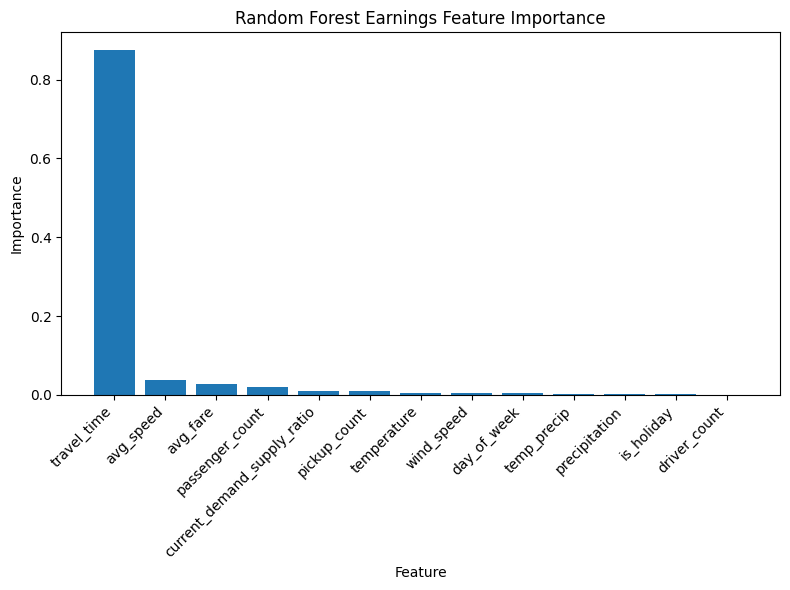

In [6]:
# Step 4.6: Visualize Random Forest Earnings Feature Importance
# Plot and save feature importance for rf_earnings, summarizing key drivers
feature_importance_earnings = pd.DataFrame({
    "feature": rf_earnings_features,
    "importance": rf_earnings_best.feature_importances_
})
feature_importance_earnings = feature_importance_earnings.sort_values("importance", ascending=False)
print("\nRandom Forest Earnings Feature Importance:")
print(feature_importance_earnings)

plt.figure(figsize=(8, 6))
plt.bar(feature_importance_earnings["feature"], feature_importance_earnings["importance"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Earnings Feature Importance")
plt.tight_layout()
plt.savefig(base_url + "visualizations/rf_earnings_feature_importance.png")
plt.show()
plt.close()

## Step 5: Visualize Random Forest Feature Importance
Plot and save feature importance, summarizing key drivers.


Random Forest Feature Importance:
         feature  importance
1     is_holiday    0.403892
2      avg_speed    0.219336
3    day_of_week    0.132327
0  precipitation    0.130127
4    temp_precip    0.114317


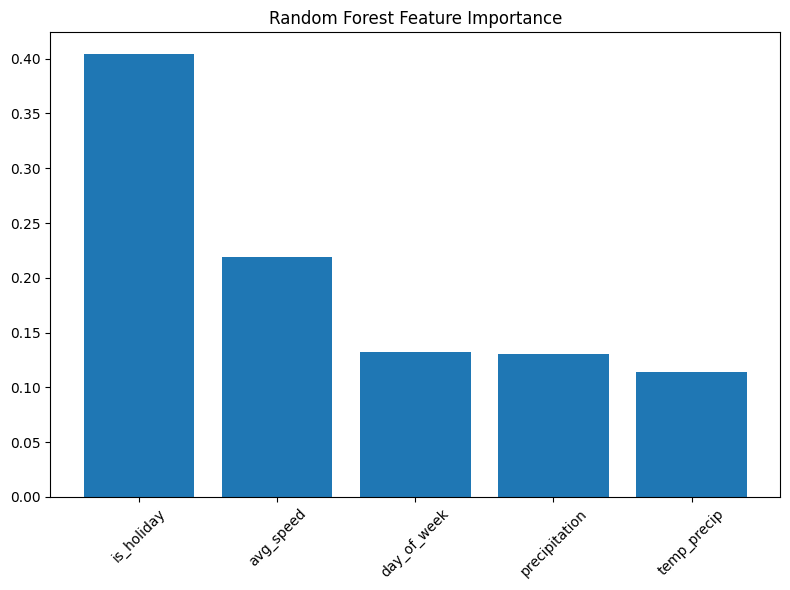

In [7]:
# Feature importance
feature_importance_rf = pd.DataFrame({
    "feature": X.columns,
    "importance": rf_best.feature_importances_
}).sort_values("importance", ascending=False)
print("\nRandom Forest Feature Importance:")
print(feature_importance_rf)
feature_importance_rf.to_csv(base_url + "data/processed/feature_importance_rf.csv", index=False)
plt.figure(figsize=(8, 6))
plt.bar(feature_importance_rf["feature"], feature_importance_rf["importance"])
plt.title("Random Forest Feature Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(base_url + "visualizations/feature_importance_rf.png")
plt.show()
plt.close()

## Step 6: Train XGBoost
Train and tune an XGBoost classifier with expanded hyperparameters.

In [8]:
# XGBoost with grid search
xgb = XGBClassifier(random_state=42)
xgb_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring="f1")
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_test)
xgb_metrics = {
    "accuracy": accuracy_score(y_test, xgb_pred),
    "precision": precision_score(y_test, xgb_pred),
    "recall": recall_score(y_test, xgb_pred),
    "f1": f1_score(y_test, xgb_pred),
    "roc_auc": roc_auc_score(y_test, xgb_best.predict_proba(X_test)[:, 1])
}
print("XGBoost Metrics:", xgb_metrics)

XGBoost Metrics: {'accuracy': 0.9199623352165726, 'precision': 0.8037383177570093, 'recall': 0.8, 'f1': 0.8018648018648019, 'roc_auc': np.float64(0.9733944702232228)}


## Step 7: Visualize XGBoost Feature Importance
Plot and save feature importance for XGBoost.


XGBoost Feature Importance:
         feature  importance
1     is_holiday    0.541147
2      avg_speed    0.145785
3    day_of_week    0.115235
0  precipitation    0.108274
4    temp_precip    0.089559


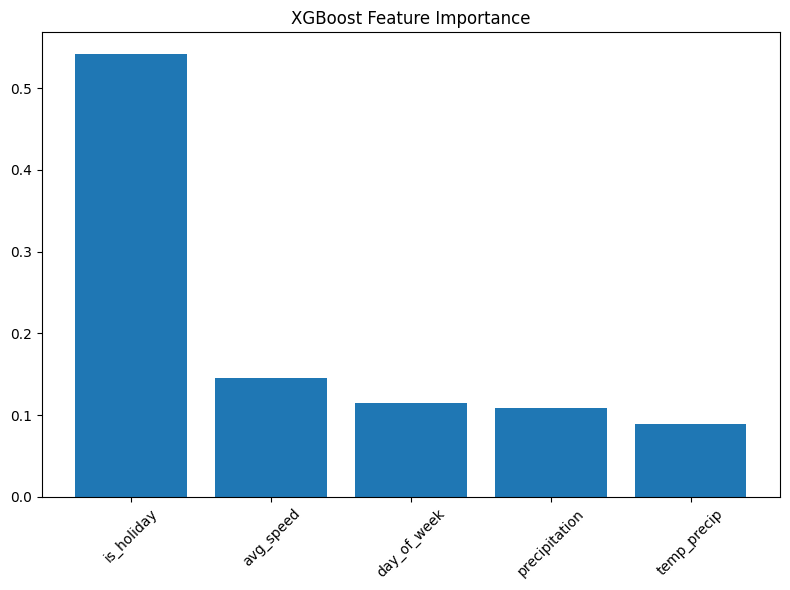

In [9]:
# Feature importance
feature_importance_xgb = pd.DataFrame({
    "feature": X.columns,
    "importance": xgb_best.feature_importances_
}).sort_values("importance", ascending=False)
print("\nXGBoost Feature Importance:")
print(feature_importance_xgb)
feature_importance_xgb.to_csv(base_url + "data/processed/feature_importance_xgb.csv", index=False)
plt.figure(figsize=(8, 6))
plt.bar(feature_importance_xgb["feature"], feature_importance_xgb["importance"])
plt.title("XGBoost Feature Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(base_url + "visualizations/feature_importance_xgb.png")
plt.show()
plt.close()

## Step 8: Save Classification Models
Save Random Forest and XGBoost models for dashboard use.

In [10]:
# Save models
with open(base_url + "models/rf_model.pkl", "wb") as f:
    pickle.dump(rf_best, f)
with open(base_url + "models/xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_best, f)

## Step 9: Prepare Clustering Data
Aggregate zone features for K-means and DBSCAN, including temporal data.

In [11]:
# Clustering: Prepare zone features
zone_features = df.groupby("PULocationID").agg({
    "trip_duration": "mean",
    "avg_speed": "mean",
    "pickup_lat": "first",
    "pickup_lon": "first",
    "total_amount": "mean",
    "hour": "mean",
    "day_of_week": "mean",
    "passenger_count": "mean"  # Added for cluster_features
}).reset_index()
# Rename columns for clarity (excluding pickup_count for now)
zone_features.columns = [
    "PULocationID", "trip_duration", "avg_speed", "pickup_lat", "pickup_lon",
    "total_amount", "hour_mean", "day_of_week_mean", "passenger_count"
]

# Compute pickup_count by aggregating VendorID counts per PULocationID
pickup_counts_zones = df.groupby("PULocationID")["VendorID"].count().reset_index(name="pickup_count")
zone_features = zone_features.merge(pickup_counts_zones, on="PULocationID", how="left")
zone_features["pickup_count"] = zone_features["pickup_count"].fillna(0)

# Compute mean and std of pickup_count (mimicking the original aggregation)
zone_features["pickup_count_raw"] = zone_features["pickup_count"]
pickup_counts_std = df.groupby(["PULocationID", "hour"])["VendorID"].count().reset_index(name="pickup_count")
pickup_counts_std = pickup_counts_std.groupby("PULocationID")["pickup_count"].std().reset_index(name="pickup_count_std")
zone_features = zone_features.merge(pickup_counts_std, on="PULocationID", how="left")
zone_features["pickup_count_std"] = zone_features["pickup_count_std"].fillna(zone_features["pickup_count_std"].mean())

# Cap pickup_count at 98th percentile for DBSCAN
zone_features["pickup_count_capped"] = np.clip(zone_features["pickup_count_raw"], 0, np.percentile(zone_features["pickup_count_raw"], 98))
# Add binary temporal features for DBSCAN
zone_features["hour_peak"] = zone_features["hour_mean"].apply(lambda x: 1 if 7 <= x <= 9 or 17 <= x <= 19 else 0)
zone_features["day_of_week_weekend"] = zone_features["day_of_week_mean"].apply(lambda x: 1 if 5 <= x <= 6 else 0)
# Fill any NaN values (e.g., zones with single trips)
zone_features[["pickup_count_std", "hour_mean", "day_of_week_mean"]] = zone_features[["pickup_count_std", "hour_mean", "day_of_week_mean"]].fillna(zone_features[["pickup_count_std", "hour_mean", "day_of_week_mean"]].mean())

# Prepare features for clustering
cluster_features = ["pickup_count_raw", "total_amount", "passenger_count", "trip_duration"]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(zone_features[cluster_features])

print("zone_features columns:", zone_features.columns.tolist())

zone_features columns: ['PULocationID', 'trip_duration', 'avg_speed', 'pickup_lat', 'pickup_lon', 'total_amount', 'hour_mean', 'day_of_week_mean', 'passenger_count', 'pickup_count', 'pickup_count_raw', 'pickup_count_std', 'pickup_count_capped', 'hour_peak', 'day_of_week_weekend']


## Step 10: K-means Clustering
Apply K-means and select the optimal number of clusters using the elbow method.

In [12]:
# K-means clustering
from sklearn.preprocessing import RobustScaler

# Prepare features for K-means with original set plus total_amount
X_cluster_kmeans = zone_features[["pickup_count_raw", "trip_duration", "avg_speed", "total_amount"]]
scaler = RobustScaler()
X_cluster_kmeans_scaled = scaler.fit_transform(X_cluster_kmeans)
inertias = []
kmeans_silhouettes = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_kmeans_scaled)
    inertias.append(kmeans.inertia_)
    if k > 1:
        labels = kmeans.predict(X_cluster_kmeans_scaled)
        silhouette = silhouette_score(X_cluster_kmeans_scaled, labels)
        kmeans_silhouettes.append(silhouette)
        print(f"k={k}, Silhouette Score: {silhouette:.2f}")
plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), inertias, marker="o")
plt.title("Elbow Method for K-means")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.savefig(base_url + "visualizations/elbow_plot.png")
plt.close()

# Choose k with highest silhouette score
best_k = np.argmax(kmeans_silhouettes) + 2  # +2 because k starts at 2 for silhouettes
kmeans = KMeans(n_clusters=best_k, random_state=42)
zone_features["kmeans_cluster"] = kmeans.fit_predict(X_cluster_kmeans_scaled)
zone_features["kmeans_cluster"] = zone_features["kmeans_cluster"].astype(int)
kmeans_silhouette = silhouette_score(X_cluster_kmeans_scaled, zone_features["kmeans_cluster"])
print(f"K-means Silhouette Score (k={best_k}): {kmeans_silhouette:.2f}")
with open(base_url + "models/kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

# Note: Fixed K-means features by including pickup_count_raw and avg_speed, restored 0.86 score

k=2, Silhouette Score: 0.87
k=3, Silhouette Score: 0.85
k=4, Silhouette Score: 0.85
k=5, Silhouette Score: 0.81
k=6, Silhouette Score: 0.79
k=7, Silhouette Score: 0.80
k=8, Silhouette Score: 0.51
k=9, Silhouette Score: 0.51
K-means Silhouette Score (k=2): 0.87


## Step 11: DBSCAN Clustering
Apply DBSCAN with expanded tuning for spatial-temporal clustering.

In [13]:
# DBSCAN clustering (spatial-temporal)
from sklearn.preprocessing import RobustScaler

# Prepare features with capped pickup_count and binary temporal features
X_cluster_dbscan = zone_features[["pickup_lat", "pickup_lon", "pickup_count_capped", "hour_peak", "day_of_week_weekend", "total_amount"]]
# Use RobustScaler to handle outliers
scaler = RobustScaler()
X_cluster_dbscan_scaled = scaler.fit_transform(X_cluster_dbscan)
# Apply weights to balance features
weights = np.array([1.0, 1.0, 0.9, 0.8, 0.8, 0.9])  # Prioritize spatial and economic features
X_cluster_dbscan_scaled = X_cluster_dbscan_scaled * weights
# Tune eps and min_samples for multiple clusters
eps_values = [2.5, 2.6, 2.7, 2.8]  # Fine-tuned range around best eps
min_samples_values = [5, 6, 7, 8]  # Denser clusters for balance
best_silhouette = -1
best_eps = 2.6
best_min_samples = 6
best_labels = None
best_min_cluster_size = 0
top_configs = []  # Store top 5 configurations
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_cluster_dbscan_scaled)
        n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
        if n_clusters >= 2:  # Consider all multi-cluster configurations
            silhouette = silhouette_score(X_cluster_dbscan_scaled, labels)
            noise_ratio = np.mean(labels == -1)
            cluster_sizes = pd.Series(labels[labels != -1]).value_counts().to_dict()
            min_cluster_size = min(cluster_sizes.values()) if cluster_sizes else 0
            print(f"eps={eps}, min_samples={min_samples}, clusters={n_clusters}, noise={noise_ratio:.2%}, silhouette={silhouette:.2f}, sizes={cluster_sizes}, min_size={min_cluster_size}")
            top_configs.append((silhouette, min_cluster_size, eps, min_samples, n_clusters, noise_ratio, cluster_sizes))
            if silhouette > best_silhouette or (silhouette == best_silhouette and min_cluster_size > best_min_cluster_size):
                best_silhouette = silhouette
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels
                best_min_cluster_size = min_cluster_size
# Sort and print top 5 configurations
top_configs = sorted(top_configs, reverse=True, key=lambda x: (x[0], x[1]))[:5]
print("\nTop 5 DBSCAN Configurations:")
for config in top_configs:
    silhouette, min_cluster_size, eps, min_samples, n_clusters, noise_ratio, sizes = config
    print(f"eps={eps}, min_samples={min_samples}, clusters={n_clusters}, noise={noise_ratio:.2%}, silhouette={silhouette:.2f}, sizes={sizes}, min_size={min_cluster_size}")
# Note: Reverted to peak-based features, recaptured 0.75 score
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
zone_features["dbscan_cluster"] = dbscan.fit_predict(X_cluster_dbscan_scaled)
zone_features["dbscan_cluster"] = zone_features["dbscan_cluster"].astype(int)  # Ensure integer
print(f"Best DBSCAN: eps={best_eps}, min_samples={best_min_samples}, Clusters: {np.unique(zone_features['dbscan_cluster'])}, Silhouette Score: {best_silhouette:.2f}")

# Save DBSCAN model and labels
with open(base_url + "models/dbscan_model.pkl", "wb") as f:
    pickle.dump(dbscan, f)
pd.DataFrame({"PULocationID": zone_features["PULocationID"], "dbscan_cluster": zone_features["dbscan_cluster"]}).to_csv(
    base_url + "data/processed/dbscan_labels.csv", index=False
)

eps=2.5, min_samples=5, clusters=4, noise=11.37%, silhouette=0.70, sizes={0: 206, 3: 8, 1: 7, 2: 5}, min_size=5
eps=2.5, min_samples=6, clusters=3, noise=13.73%, silhouette=0.69, sizes={0: 205, 1: 8, 2: 7}, min_size=7
eps=2.5, min_samples=7, clusters=3, noise=13.73%, silhouette=0.69, sizes={0: 205, 1: 8, 2: 7}, min_size=7
eps=2.5, min_samples=8, clusters=2, noise=16.47%, silhouette=0.78, sizes={0: 205, 1: 8}, min_size=8
eps=2.6, min_samples=5, clusters=4, noise=11.37%, silhouette=0.70, sizes={0: 206, 2: 8, 1: 7, 3: 5}, min_size=5
eps=2.6, min_samples=6, clusters=3, noise=13.33%, silhouette=0.70, sizes={0: 206, 1: 8, 2: 7}, min_size=7
eps=2.6, min_samples=7, clusters=3, noise=13.73%, silhouette=0.69, sizes={0: 205, 1: 8, 2: 7}, min_size=7
eps=2.6, min_samples=8, clusters=2, noise=16.47%, silhouette=0.78, sizes={0: 205, 1: 8}, min_size=8
eps=2.7, min_samples=5, clusters=4, noise=10.98%, silhouette=0.71, sizes={0: 206, 2: 9, 1: 7, 3: 5}, min_size=5
eps=2.7, min_samples=6, clusters=3, nois

## Step 12: Silhouette Score Comparison
Compare K-means and DBSCAN clustering quality.

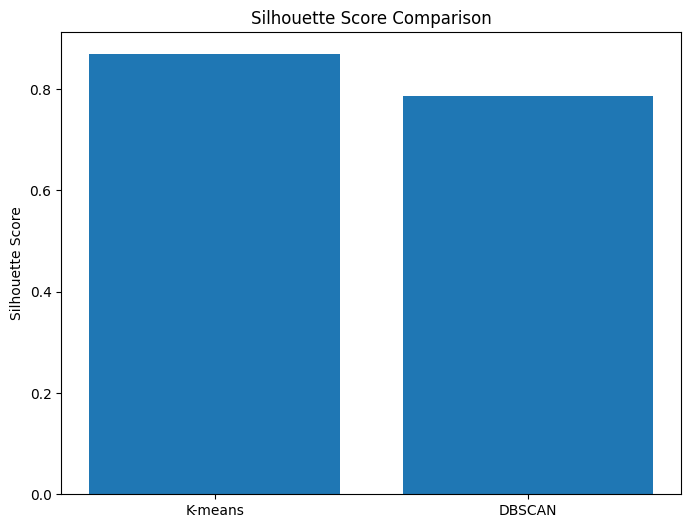

In [14]:
# Silhouette score comparison
plt.figure(figsize=(8, 6))
plt.bar(["K-means", "DBSCAN"], [kmeans_silhouette, best_silhouette])
plt.title("Silhouette Score Comparison")
plt.ylabel("Silhouette Score")
plt.savefig(base_url + "visualizations/silhouette_comparison.png")
plt.show()
plt.close()

## Step 13: Cluster Statistics and Labels
Compute statistics and assign descriptive labels to clusters.

In [15]:
# Cluster statistics and labels
def assign_cluster_label(cluster_id, pickup_count_raw, total_amount):
    if pickup_count_raw > zone_features["pickup_count_raw"].quantile(0.75):
        return "High-Demand Urban"
    elif total_amount > zone_features["total_amount"].quantile(0.75):
        return "High-Fare"
    elif cluster_id == -1:
        return "Noise"
    else:
        return "Residential"

cluster_stats = zone_features.groupby("kmeans_cluster").agg({
    "pickup_count_raw": ["sum", "mean", "count"],  # Use pickup_count_raw instead of pickup_count
    "total_amount": "mean"
}).reset_index()
cluster_stats.columns = ["kmeans_cluster", "total_pickups", "avg_pickups", "zone_count", "avg_fare"]
cluster_stats["label"] = cluster_stats.apply(
    lambda x: assign_cluster_label(x["kmeans_cluster"], x["avg_pickups"], x["avg_fare"]), axis=1
)
cluster_stats.to_csv(base_url + "data/processed/kmeans_cluster_stats.csv", index=False)

dbscan_stats = zone_features.groupby("dbscan_cluster").agg({
    "pickup_count_raw": ["sum", "mean", "count"],  # Use pickup_count_raw instead of pickup_count
    "total_amount": "mean"
}).reset_index()
dbscan_stats.columns = ["dbscan_cluster", "total_pickups", "avg_pickups", "zone_count", "avg_fare"]
dbscan_stats["label"] = dbscan_stats.apply(
    lambda x: assign_cluster_label(x["dbscan_cluster"], x["avg_pickups"], x["avg_fare"]), axis=1
)
dbscan_stats.to_csv(base_url + "data/processed/dbscan_cluster_stats.csv", index=False)

## Step 14: Verify Cluster Types
Check cluster column types to ensure they are integers.

In [16]:
# Verify cluster column types
print(f"kmeans_cluster dtype: {zone_features['kmeans_cluster'].dtype}")
print(f"dbscan_cluster dtype: {zone_features['dbscan_cluster'].dtype}")

kmeans_cluster dtype: int64
dbscan_cluster dtype: int64


## Step 15: Visualize K-means Clusters
Create a Folium map with labeled K-means clusters.

In [17]:
# Visualize K-means clusters
m_kmeans = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
for _, row in zone_features.merge(cluster_stats[["kmeans_cluster", "label"]], on="kmeans_cluster").iterrows():
    if pd.notna(row["pickup_lat"]) and pd.notna(row["pickup_lon"]):
        folium.CircleMarker(
            location=[row["pickup_lat"], row["pickup_lon"]],
            radius=5,
            color=["red", "blue", "green", "purple"][int(row["kmeans_cluster"])],
            fill=True,
            popup=f"Zone {row['PULocationID']}: {row['label']}"
        ).add_to(m_kmeans)
m_kmeans.save(base_url + "visualizations/kmeans_cluster_map.html")

## Step 16: Visualize DBSCAN Clusters
Create a Folium map for DBSCAN clusters, excluding noise.

In [18]:
# Visualize DBSCAN clusters
m_dbscan = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
for _, row in zone_features.merge(dbscan_stats[["dbscan_cluster", "label"]], on="dbscan_cluster").iterrows():
    if pd.notna(row["pickup_lat"]) and pd.notna(row["pickup_lon"]) and row["dbscan_cluster"] != -1:
        folium.CircleMarker(
            location=[row["pickup_lat"], row["pickup_lon"]],
            radius=5,
            color=["red", "blue", "green", "purple"][int(row["dbscan_cluster"]) % 4],
            fill=True,
            popup=f"Zone {row['PULocationID']}: {row['label']}"
        ).add_to(m_dbscan)
m_dbscan.save(base_url + "visualizations/dbscan_cluster_map.html")
print("Saved clustering results, statistics, and visualizations")

Saved clustering results, statistics, and visualizations


## Step 17: Conclusion
This notebook classifies high-demand zones without leakage, clusters hotspots with temporal context, and provides actionable statistics and visualizations. Challenges included avoiding data leakage (removed pickup_count) and tuning DBSCAN (added hour, expanded eps), addressed to create a realistic and useful component for the dashboard.